# 🏔️ From Gradient descent to Adam

## Introduction

Function optimization is a central problem in applied mathematics, machine learning, and engineering. Given a real-valued function $ f : \mathbb{R}^n \to \mathbb{R} $, the goal of optimization is to find the input $ x^\star \in \mathbb{R}^n $ that minimizes the function:
$$
x^\star = \arg\min_{x \in \mathbb{R}^n} f(x).
$$

We distinguish between two types of minima:


- A $ x^\star $ is a global minimum of $ f $ if
$$
\forall x \in \mathbb{R}^n, \quad f(x^\star) \leq f(x).
$$
- A $ x^\star $ is a local minimum of $ f $ if there exists $ \varepsilon > 0 $ such that
$$
\forall x \in \mathbb{R}^n, \ \|x - x^\star\| < \varepsilon \Rightarrow f(x^\star) \leq f(x).
$$

In this notebook, we will explore different numerical techniques for finding minima of a differentiable function $ f : \mathbb{R}^2 \to \mathbb{R} $. Visualizations will accompany each method to provide geometric intuition and illustrate convergence behavior.

#### Summary: 
- Gradient Descent
- Gradient descent with Momentum
- Nesterov Accelerated Gradients
- Adagrad
- RMSProp
- Adam


First, let's plot the function we are going to optimize and compute its global and local minimum with scipy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
np.random.seed(42)

def f_vec(xy):
    x, y = xy
    return x**2 + y**2 + np.sin(3*x + y)

global_min = minimize(f_vec, [0, 0]).x
print("Global minimum :", global_min)

local_min = minimize(f_vec, [1, 1]).x
print("Local minimum :", local_min)

Global minimum : [-0.39193201 -0.130644  ]
Local minimum : [1.15124015 0.38374672]


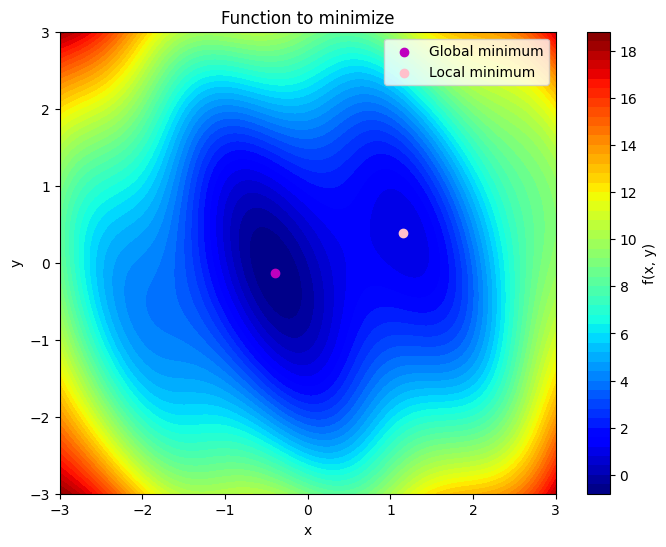

In [338]:

def f(x, y):
    return x**2 + y**2 + np.sin(3*x + y)  


def grad(x, y, h=1e-5):
    df_dx = (f(x + h, y) - f(x - h, y)) / (2 * h)
    df_dy = (f(x, y + h) - f(x, y - h)) / (2 * h)
    return np.array([df_dx, df_dy])


def plot_fonction(f, history=None):
    x = np.linspace(-3, 3, 300)
    y = np.linspace(-3, 3, 300)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z, levels=50, cmap='jet')
    plt.colorbar(contour, label='f(x, y)')

    if history is not None:
        history = np.array(history)
        plt.plot(history[:, 0], history[:, 1], color='white', lw=1.5, zorder=5, label='Optimization path')
        plt.scatter(history[:, 0], history[:, 1], color='white', s=15, zorder=5)
    
    plt.scatter(x=global_min[0], y=global_min[1], color='m', zorder=10, label='Global minimum')
    plt.scatter(x=local_min[0], y=local_min[1], color='pink', zorder=10, label='Local minimum')
    plt.title("Function to minimize")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
        

plot_fonction(f)

## Gradient descent

Gradient descent is an iterative numerical optimization method used to minimize a differentiable function $ f : \mathbb{R}^n \to \mathbb{R} $. The main idea is based on the fact that the gradient $ \nabla f(x) $ indicates the direction of greatest increase in the function. Therefore, to minimize $ f $, we move in the opposite direction to the gradient.

Starting from an initial x $ x_0 \in \mathbb{R}^n $, gradient descent generates a sequence of iterations $ (x_k)_{k \in \mathbb{N}} $ according to the following update rule:
$$
x_{k+1} = x_k - \eta \nabla f(x_k),
$$
where $ \eta > 0 $ is the learning rate, a hyperparameter controlling the size of the step taken at each iteration.

Under certain conditions (for example, if $ f $ is convex and the gradient is Lipschitz), this method converges to a stationary x of $ f $, which is a global minimum in the convex case. The performance of gradient descent depends heavily on the choice of $ \eta $; too small slows down convergence, too large can prevent convergence.

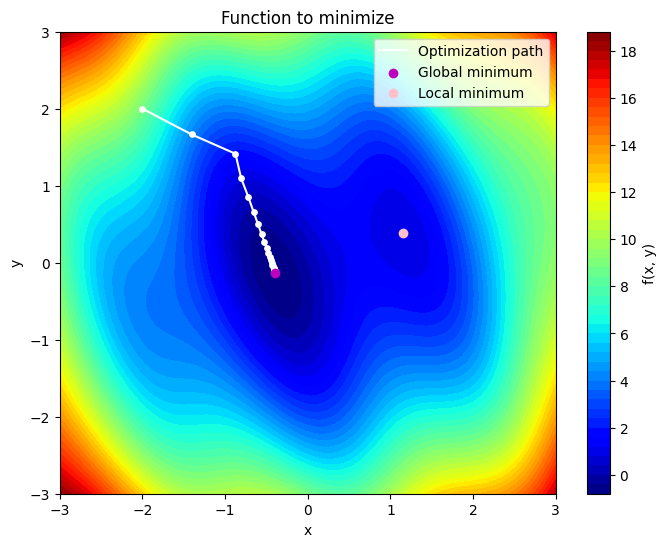

Iteration number:  36


In [340]:

def gradient_descent(x0, lr=0.1, iter_max=1000):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    res = 1
    iter = 0

    while res > 1e-3 and iter < iter_max:
        gradient = grad(x[0], x[1])
        x -= lr * gradient
        
        res = np.linalg.norm(global_min - x)
        history.append(x.copy())
        iter += 1

    return history, iter



x0 = [-2.0, 2.0]
# x0 = [2.5, 0] # uncomment to test local minimum
history, n_iter = gradient_descent(x0)
plot_fonction(f, history)
print("Iteration number: ", n_iter)


Note: Gradient descent can't escape local minimums as it only follows the steepest descent. You can uncomment the line 21 to see it converges to a local minimum of the function. Let's see another optimization algorithm that can escape them.

## Gradient descent with Momentum
Gradient descent with momentum (or inertia) is a variant of the classic gradient descent method, introduced to improve convergence speed and mitigate oscillations, particularly in narrow valleys or regions of high anisotropy in the function landscape. The main idea is to keep a memory of previous descent directions, accumulating a velocity that guides the current iteration.
More formally, at each iteration $ k $, a velocity vector $ v_k $ is introduced and updated according to the following rule:
$$
v_{k+1} = \mu v_k - \eta \nabla f(x_k),
$$
$$
x_{k+1} = x_k + v_{k+1},
$$
where $ \eta > 0 $ is the learning rate and $ \mu \in [0, 1 [ $ is the momentum coefficient. The term $ \mu v_k $ acts as an inertia that propagates the effects of past gradients in the current direction, accelerating convergence in consistent directions and smoothing out sudden variations due to uninformative local gradients.
Intuitively, this method works like a ball rolling down a landscape: it gains speed as it descends a slope and maintains that speed even when the slope temporarily flattens out. This allows it to move faster toward the minimum while avoiding getting trapped in small local minima or slowing down excessively on plateaus.
Descent with momentum is particularly effective in functions with directions where the curvature varies greatly (i.e., where the components of the gradient have very different magnitudes). 

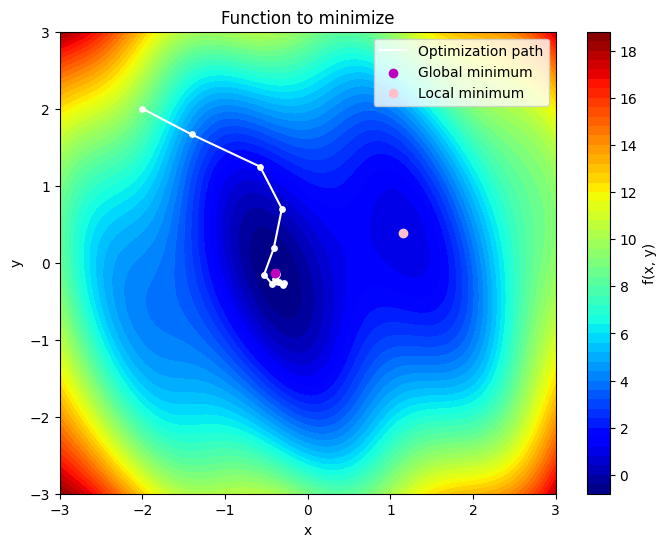

Iteration number:  21


In [ ]:
def gradient_descent_momentum(x0, lr=0.1, beta=0.5, iter_max=1000):
    x = np.array(x0, dtype=float)
    velocity = np.zeros_like(x)  # terme d'inertie initialisé à 0
    history = [x.copy()]
    res = 1
    iter = 0

    while res > 1e-3 and iter < iter_max:
        gradient = grad(x[0], x[1])
        velocity = beta * velocity - lr * gradient
        x += velocity

        res = np.linalg.norm(global_min - x)
        history.append(x.copy())
        iter += 1

    return history, iter


x0 = [-2.0, 2.0]
# x0 = [2.5, 0] # uncomment to test local minimum
history, n_iter = gradient_descent_momentum(x0)
plot_fonction(f, history)
print("Iteration number: ", n_iter)

## Nesterov Accelerated Gradient

Nesterov Accelerated Gradient is an improvement over classical momentum-based gradient descent. The key idea behind Nesterov’s method is to look ahead at the future position of the parameters before computing the gradient. This anticipatory behavior helps the algorithm converge faster and more smoothly, especially in situations where the objective function has pathological curvature or ravines.

Instead of computing the gradient at the current position $ x_k $, Nesterov’s method computes it at a look-ahead x $ x_k + \mu v_k $, where $ v_k $ is the current velocity (momentum term) and $ \mu \in [0, 1) $ is the momentum coefficient.

The update rule is given by:

$$
v_{k+1} = \mu v_k - \eta \nabla f(x_k + \mu v_k)
$$

$$
x_{k+1} = x_k + v_{k+1}
$$

Here:
- $ \eta $ is the learning rate,
- $ \mu $ is the momentum parameter (typically around 0.9),
- $ \nabla f(\cdot) $ is the gradient of the objective function.

Compared to classical momentum, Nesterov's method provides a more responsive and adaptive update, as it uses the gradient evaluated at the projected next position, rather than the current one. This subtle change often leads to improved convergence rates, especially in deep learning and convex optimization problems.


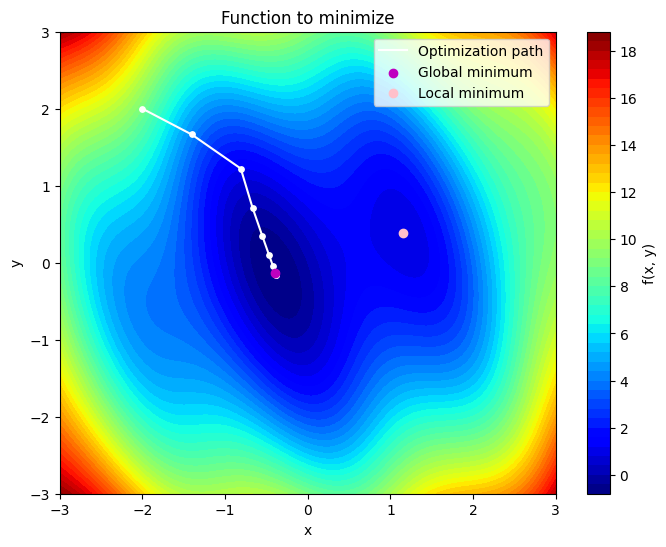

Iteration number:  16


In [339]:
def gradient_descent_nesterov(x0, lr=0.1, beta=0.5, iter_max=1000):
    x = np.array(x0, dtype=float)
    velocity = np.zeros_like(x) 
    history = [x.copy()]
    res = 1
    iter = 0

    while res > 1e-3 and iter < iter_max:
        gradient = grad(x[0] + beta * velocity[0], x[1] + beta * velocity[1])
        velocity = beta * velocity - lr * gradient
        x += velocity

        res = np.linalg.norm(global_min - x)
        history.append(x.copy())
        iter += 1

    return history, iter


x0 = [-2.0, 2.0]
history, n_iter = gradient_descent_nesterov(x0)
plot_fonction(f, history)
print("Iteration number: ", n_iter)

## Adagrad

Adagrad (Adaptive Gradient Algorithm) is an optimization method that adapts the learning rate for each parameter individually during training. This is particularly useful when dealing with sparse data or when some parameters require more fine-grained updates than others.

The key idea is to scale the learning rate inversely proportional to the square root of the sum of all historical squared gradients. As training progresses, frequently updated parameters receive smaller updates, while infrequently updated ones receive larger updates.

Let $ x_k \in \mathbb{R}^n $ be the parameter vector at iteration $ k $ and $ \otimes $ denotes element-wise multiplication. The update rule for Adagrad is:

$$
s = s + \nabla f(x_k) \otimes \nabla f(x_k)
$$
$$
x_{k+1} = x_k - \eta \nabla f(x_k) \otimes \frac{1}{\sqrt{s + \epsilon}}
$$

Here:

- $ \eta $ is the global learning rate,
- $ \epsilon $ is a small constant (e.g., $ 10^{-8} $) to avoid division by zero,
- $ G_k \in \mathbb{R}^n $ accumulates the squared gradients element-wise.

Adagrad is particularly effective in convex problems and natural language processing tasks involving sparse features. However, a known limitation is that the learning rates can decay too aggressively, eventually becoming too small for continued learning.


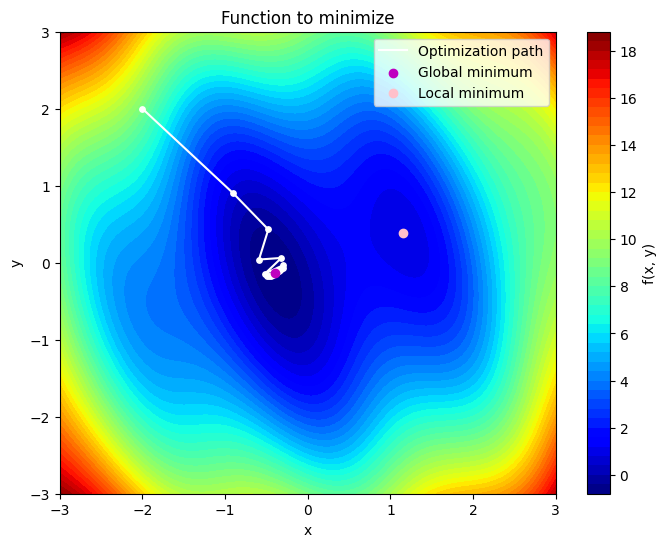

Iteration number:  40


In [ ]:
def adagrad(x0, lr=1.1, iter_max=1000):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    velocity = np.zeros_like(x)
    epsilon = 1e-6
    res = 1
    iter = 0

    while res > 1e-3 and iter < iter_max:
        gradient = grad(x[0], x[1])
        velocity += gradient * gradient
        x -= lr * gradient / np.sqrt(velocity + epsilon)

        res = np.linalg.norm(global_min - x)
        history.append(x.copy())
        iter += 1

    return history, iter


x0 = [-2.0, 2.0]
history, n_iter = adagrad(x0)
plot_fonction(f, history)
print("Iteration number: ", n_iter)

## RMSProp

RMSProp (Root Mean Square Propagation) is an adaptive learning rate optimization algorithm designed to overcome the diminishing learning rate problem in Adagrad. While Adagrad accumulates all past squared gradients, which can lead to an ever-growing denominator and vanishing updates, RMSProp uses an exponentially decaying average of past squared gradients to maintain a more stable and bounded update rule.

RMSProp algorithm is the following:

$$
s = \rho s + (1 - \rho) \nabla f(x_k) \otimes \nabla f(x_k)
$$
$$
x_{k+1} = x_k - \eta \nabla f(x_k) \otimes \frac{1}{\sqrt{s + \epsilon}}
$$


where:
- $ \rho \in [0, 1) $ is the decay rate, typically set to 0.9,
- $ \eta $ is the learning rate,
- $ \epsilon $ is a small constant (e.g., $ 10^{-8} $) to avoid division by zero.


RMSProp adjusts the learning rate for each parameter based on the recent magnitude of its gradients, allowing the algorithm to adaptively slow down updates for parameters with consistently large gradients. This makes RMSProp well-suited for training non-convex functions such as deep neural networks and recurrent neural networks.


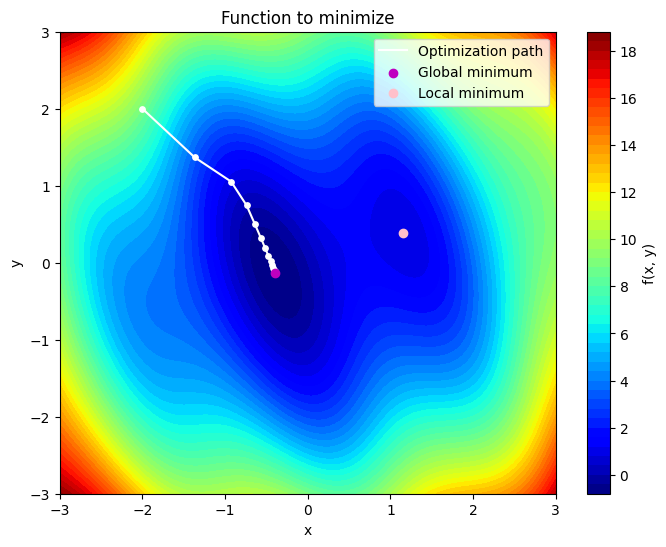

Iteration number:  18


In [ ]:
def RMSProp(x0, lr=0.2, rho=0.9, iter_max=1000):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    res = 1
    iter = 0
    epsilon = 1e-6
    velocity = np.zeros_like(x) + epsilon

    while res > 1e-3 and iter < iter_max:
        gradient = grad(x[0], x[1])
        velocity = rho * velocity + (1 - rho) * gradient * gradient
        x -= lr * gradient / np.sqrt(velocity + epsilon)

        res = np.linalg.norm(global_min - x)
        history.append(x.copy())
        iter += 1

    return history, iter


x0 = [-2.0, 2.0]
history, n_iter = RMSProp(x0)
plot_fonction(f, history)
print("Iteration number: ", n_iter)

## Adam

Adam (Adaptive Moment Estimation) is one of the most widely used optimization algorithms in deep learning. It combines the benefits of two popular methods: Momentum and RMSProp. Adam maintains an exponentially decaying average of past gradients (like momentum) and an exponentially decaying average of past squared gradients (like RMSProp), and uses both to adapt the learning rate for each parameter.

Adam maintains two moving averages:

- The first moment estimate (mean of gradients):
  $$
  m = \beta_1 m + (1 - \beta_1) \nabla f(x_k)
  $$

- The second moment estimate (uncentered variance of gradients):
  $$
  s = \beta_2 s + (1 - \beta_2) \nabla f(x_k) \otimes \nabla f(x_k)
  $$

The parameters $\beta_1, \beta_2 \in [0, 1)$ are decay rates (commonly $\beta_1 = 0.9$, $\beta_2 = 0.999$).

Since $m_k$ and $v_k$ are initialized at zero, Adam includes a bias-correction step to counteract the initialization effects:

$$
\hat{m} = \frac{m}{1 - \beta_1^k}, \quad \hat{v} = \frac{v}{1 - \beta_2^k}
$$

The parameters are then updated as follows:

$$
x_{k+1} = x_k - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \otimes \hat{m}
$$

Adam has become a standard optimizer due to its fast convergence and robustness to noisy or sparse gradients. It is especially effective for training deep neural networks and large-scale machine learning models.


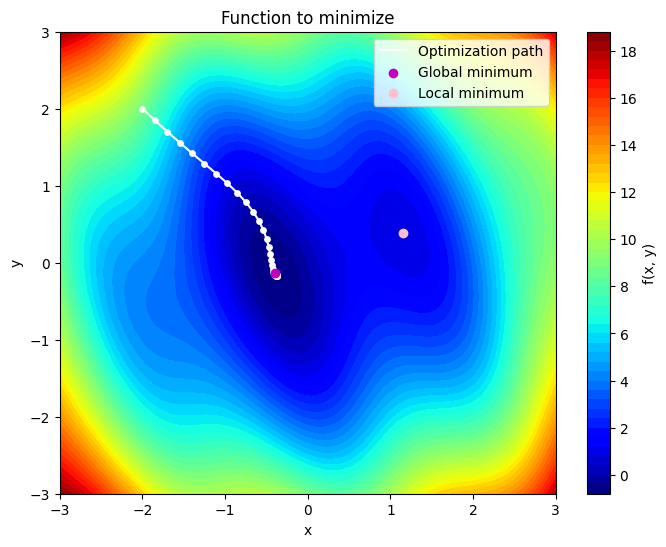

Iteration number:  37


In [330]:
def adam(x0, lr=0.15, beta1=0.7, beta2 = 0.999, iter_max=1000):
    x = np.array(x0, dtype=float)
    s = np.zeros_like(x)
    m = np.zeros_like(x)
    history = [x.copy()]
    epsilon = 1e-6
    res = 1
    iter = 1

    while res > 1e-3 and iter < iter_max:
        gradient = grad(x[0], x[1])
        m = beta1 * m - (1 - beta1) * gradient
        s = beta2 * s + (1 - beta2) * gradient * gradient
        m_hat = m / (1 - beta1 ** iter)
        s_hat = s / (1 - beta2 ** iter)
        x += lr * m_hat / np.sqrt(s_hat + epsilon)

        res = np.linalg.norm(global_min - x)
        history.append(x.copy())
        iter += 1

    return history, iter


x0 = [-2.0, 2.0]
history, n_iter = adam(x0)
plot_fonction(f, history)
print("Iteration number: ", n_iter)